In [1]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import nltk
from nltk.corpus import reuters
import pandas as pd

# Download necessary datasets
nltk.download('reuters')
nltk.download('punkt')

def reuters_to_dataframe():
    data = []
    for file_id in reuters.fileids():  # Loop through all articles
        categories = ', '.join(reuters.categories(file_id))  # Join categories with commas
        content = reuters.raw(file_id).strip()  # Strip unnecessary whitespace
        data.append({"File ID": file_id, "Categories": categories, "Content": content})
    
    # Convert the data into a DataFrame
    df = pd.DataFrame(data)
    return df

# Generate the table for the entire dataset
df_reuters = reuters_to_dataframe()

# Print the dataset summary and head
print(f"Total rows: {len(df_reuters)}")
print(df_reuters.head())  # Display the first few rows

# Optional: Save to a CSV file
df_reuters.to_csv("reuters_dataset_full.csv", index=False)

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Cherith\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cherith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total rows: 10788
      File ID                                    Categories  \
0  test/14826                                         trade   
1  test/14828                                         grain   
2  test/14829                                crude, nat-gas   
3  test/14832  corn, grain, rice, rubber, sugar, tin, trade   
4  test/14833                             palm-oil, veg-oil   

                                             Content  
0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...  
1  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...  
2  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...  
3  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...  
4  INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...  


In [3]:
import nltk
from nltk.tokenize import sent_tokenize
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Tokenizer setup
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Prepare the Reuters dataset for training
def preprocess_reuters_data(df):
    sentences, labels = [], []
    causal_indicators = ["caused by", "led to", "due to", "triggered", "resulted in", "owing to"]

    for _, row in df.iterrows():
        content = row["Content"]
        category = row["Categories"]

        # Tokenize content into sentences
        for sentence in sent_tokenize(content):
            sentences.append(sentence)
            # Simulated label: Check for causal indicators
            label = int(any(indicator in sentence.lower() for indicator in causal_indicators))
            labels.append(label)

    return sentences, labels

# Load and preprocess the dataset
sentences, labels = preprocess_reuters_data(df_reuters)
print(f"Preprocessed {len(sentences)} sentences.")

c:\Users\Cherith\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Preprocessed 53792 sentences.


In [4]:
class ReutersDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        # Tokenize the sentence
        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create Dataset and DataLoader
dataset = ReutersDataset(sentences, labels, tokenizer, max_len=128)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

c:\Users\Cherith\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Cherith\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Train Loss: 0.0365 - Val Loss: 0.0108
Epoch 2/10 - Train Loss: 0.0099 - Val Loss: 0.0110
Epoch 3/10 - Train Loss: 0.0079 - Val Loss: 0.0087
Epoch 4/10 - Train Loss: 0.0050 - Val Loss: 0.0079
Epoch 5/10 - Train Loss: 0.0047 - Val Loss: 0.0064
Epoch 6/10 - Train Loss: 0.0039 - Val Loss: 0.0132
Epoch 7/10 - Train Loss: 0.0033 - Val Loss: 0.0082
Early stopping triggered.


C:\Users\Cherith\AppData\Local\Temp\ipykernel_23816\3387506787.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))



Classification Report:
              precision    recall  f1-score   support

  Non-Causal       1.00      1.00      1.00     10560
      Causal       0.92      0.99      0.96       199

    accuracy                           1.00     10759
   macro avg       0.96      0.99      0.98     10759
weighted avg       1.00      1.00      1.00     10759



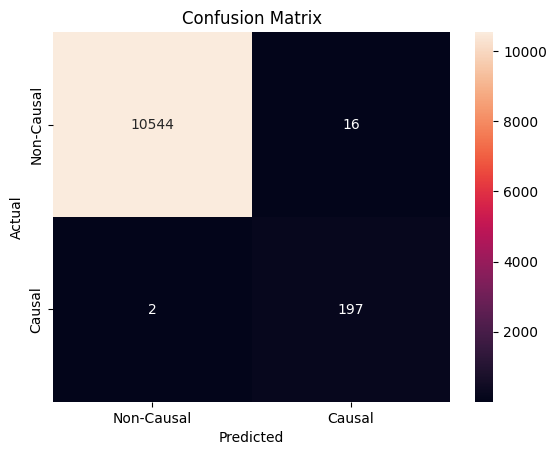


Sample Predictions:
Sentence: Cash dividend is payable April 30 to holders of
  record April 15.
True Label: Non-Causal
Predicted Label: Non-Causal
Prediction Confidence: 1.0000

Sentence: Last year, Taiwanese breakers demolished a record 344
  vessels totalling 3.69 million light displacement tons (ldt),
  up on 165 of 2.97 million ldt in 1985, Lin Chung-jung, a Taiwan
  Shipbreaking Industry Association (TSIA) spokesman, told
  Reuters.
True Label: Non-Causal
Predicted Label: Non-Causal
Prediction Confidence: 1.0000

Sentence: INDIA 1986/87 COTTON EXPORT QUOTA UP 190,000 BALES
  India's raw cotton export quota has
  been raised by 190,000 170-kg bales to 600,000 bales in 1986/87
  ending August, still well below the 1985/86 quota of 1.35 mln
  bales, Minister of State for Textiles R.N.
True Label: Non-Causal
Predicted Label: Non-Causal
Prediction Confidence: 1.0000

Sentence: The company did not disclose the details of the revised
  offers, but said a special committee of its board 

In [5]:
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load BERT model and set dropout probabilities
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.config.hidden_dropout_prob = 0.5  # Increase dropout
model.config.attention_probs_dropout_prob = 0.5

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up AdamW optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)  # Lower learning rate and increase weight decay

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

# Create Datasets and DataLoaders
train_dataset = ReutersDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = ReutersDataset(val_texts, val_labels, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Function to calculate validation loss
def compute_validation_loss(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()

    return total_loss / len(val_loader)

# Early stopping and training with modified parameters
EPOCHS = 10
patience = 2  # Stop after 2 consecutive epochs without improvement
best_loss = float('inf')
counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    # Training phase
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    # Validation phase
    val_loss = compute_validation_loss(model, val_loader)
    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {total_train_loss / len(train_loader):.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on validation set
true_labels, pred_labels, pred_probs = [], [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()

        true_labels.extend(labels)
        pred_labels.extend(preds)
        pred_probs.extend(probs)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Non-Causal", "Causal"]))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Non-Causal", "Causal"], yticklabels=["Non-Causal", "Causal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print some example predictions with probabilities
print("\nSample Predictions:")
for i in range(10):
    print(f"Sentence: {val_texts[i]}")
    print(f"True Label: {'Causal' if val_labels[i] == 1 else 'Non-Causal'}")
    print(f"Predicted Label: {'Causal' if pred_labels[i] == 1 else 'Non-Causal'}")
    print(f"Prediction Confidence: {pred_probs[i][pred_labels[i]]:.4f}\n")

In [6]:


# Print some example predictions with probabilities
print("\nSample Predictions:")
for i in range(20):
    print(f"Sentence: {val_texts[i]}")
    print(f"True Label: {'Causal' if val_labels[i] == 1 else 'Non-Causal'}")
    print(f"Predicted Label: {'Causal' if pred_labels[i] == 1 else 'Non-Causal'}")
    print(f"Prediction Confidence: {pred_probs[i][pred_labels[i]]:.4f}\n")


Sample Predictions:
Sentence: Cash dividend is payable April 30 to holders of
  record April 15.
True Label: Non-Causal
Predicted Label: Non-Causal
Prediction Confidence: 1.0000

Sentence: Last year, Taiwanese breakers demolished a record 344
  vessels totalling 3.69 million light displacement tons (ldt),
  up on 165 of 2.97 million ldt in 1985, Lin Chung-jung, a Taiwan
  Shipbreaking Industry Association (TSIA) spokesman, told
  Reuters.
True Label: Non-Causal
Predicted Label: Non-Causal
Prediction Confidence: 1.0000

Sentence: INDIA 1986/87 COTTON EXPORT QUOTA UP 190,000 BALES
  India's raw cotton export quota has
  been raised by 190,000 170-kg bales to 600,000 bales in 1986/87
  ending August, still well below the 1985/86 quota of 1.35 mln
  bales, Minister of State for Textiles R.N.
True Label: Non-Causal
Predicted Label: Non-Causal
Prediction Confidence: 1.0000

Sentence: The company did not disclose the details of the revised
  offers, but said a special committee of its board 